In [1]:
import numpy as np
import pandas as pd

# Viz
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


In [2]:
# Load the dataset
df = pd.read_csv("data/Walmart_Store_sales.csv")

In [3]:
# Basic stats
print("Number of rows : {}".format(df.shape[0]))
print()

print("Display of dataset: ")
display(df.head())
print()

print("Basics statistics: ")
data_desc = df.describe(include="all")
display(data_desc)
print()

print("Percentage of missing values: ")
display(100 * df.isnull().sum() / df.shape[0])

df.info()

Number of rows : 150

Display of dataset: 


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092



Basics statistics: 


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,132,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
unique,NaN,85,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,19-10-2012,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.866667,NaN,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,NaN,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,NaN,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,NaN,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000



Percentage of missing values: 


Store            0.000000
Date            12.000000
Weekly_Sales     9.333333
Holiday_Flag     8.000000
Temperature     12.000000
Fuel_Price       9.333333
CPI              8.000000
Unemployment    10.000000
dtype: float64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         150 non-null    float64
 1   Date          132 non-null    object 
 2   Weekly_Sales  136 non-null    float64
 3   Holiday_Flag  138 non-null    float64
 4   Temperature   132 non-null    float64
 5   Fuel_Price    136 non-null    float64
 6   CPI           138 non-null    float64
 7   Unemployment  135 non-null    float64
dtypes: float64(7), object(1)
memory usage: 9.5+ KB


#### Dimension et structure du dataset
- Le dataset contient 150 lignes et 8 colonnes (=> peu de données).
- Les variables disponibles sont:
    - Store: identifiant des magasins (1 à 20) - variable catégorielle nominale discrète
    - Date: variable temporelle
    - Weekly_Sales: ventes hebdomadaires (en dollars) - variable numérique continue
        - moyenne: 1.25 M$
        - min: 0.27 M$, max: 2.77 M$
        - Grande variabilité - cela indique une forte disparité des ventes selon les magasins et/ou périodes
    - Holiday_Flag: indicateur binaire (1 si jour férié, 0 sinon) - variable catégorielle binaire - peu de valeurs à 1 
    - Temperature: température moyenne (°F) - variable numérique continue
    - Fuel_Price: prix moyen du carburant (dollars) - variable numérique continue
    - CPI: Consumer Price Index (indice des prix à la consommation) - variable numérique continue
    - Unemployment: taux de chômage (en %) - variable numérique continue

#### Valeurs manquantes
- Date et Temperature: 12%
- Weekly_Sales et Fuel_Price: 9.33%
- Holiday_Flag et CPI: 8%
- Unemployment: 10%

- Target quantitative (Weekly_Sales) => régression
- Objectif : Prédire les ventes hebdomadaires 

## Preprocessing

In [4]:
# Exclude rows where the target variable (Y) 'Weekly_Sales' is missing
df_clean = df[df['Weekly_Sales'].notna()].copy()

In [5]:
len(df_clean)

136

In [6]:
# Convert the 'Date' column to datetime format (with day first)
df_clean['Date'] = pd.to_datetime(df_clean['Date'], dayfirst=True)

# Extract date features
df_clean['year'] = df_clean['Date'].dt.year
df_clean['month'] = df_clean['Date'].dt.month
df_clean['day_of_month'] = df_clean['Date'].dt.day
df_clean['day_of_year'] = df_clean['Date'].dt.dayofyear
df_clean['day_of_week'] = df_clean['Date'].dt.dayofweek

# Drop the 'Date' column as it is no longer needed
df_clean.drop(columns=['Date'], inplace=True)

df_clean.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,day_of_month,day_of_year,day_of_week
0,6.0,1572117.54,NaN,59.61,3.045,214.777523,6.858,2011.0,2.0,18.0,49.0,4.0
1,13.0,1807545.43,0.0,42.38,3.435,128.616064,7.470,2011.0,3.0,25.0,84.0,4.0
3,11.0,1244390.03,0.0,84.57,NaN,214.556497,7.346,NaN,NaN,NaN,NaN,NaN
4,6.0,1644470.66,0.0,78.89,2.759,212.412888,7.092,2010.0,5.0,28.0,148.0,4.0
5,4.0,1857533.70,0.0,NaN,2.756,126.160226,7.896,2010.0,5.0,28.0,148.0,4.0


In [7]:
# Display sorted unique values for selected categorical and date-related columns
for col in ['Store', 'Holiday_Flag', 'year', 'month', 'day_of_month', 'day_of_year', 'day_of_week']:
    print(f"\nValeurs uniques de '{col}':")
    print(sorted(df_clean[col].unique()))


Valeurs uniques de 'Store':
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0]

Valeurs uniques de 'Holiday_Flag':
[nan, 0.0, 1.0]

Valeurs uniques de 'year':
[2011.0, nan, 2010.0, 2012.0]

Valeurs uniques de 'month':
[2.0, 3.0, nan, 1.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0]

Valeurs uniques de 'day_of_month':
[18.0, 25.0, nan, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 19.0, 20.0, 22.0, 23.0, 24.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0]

Valeurs uniques de 'day_of_year':
[6.0, 49.0, 84.0, nan, 7.0, 13.0, 20.0, 34.0, 36.0, 41.0, 43.0, 48.0, 50.0, 55.0, 57.0, 62.0, 71.0, 76.0, 85.0, 90.0, 92.0, 105.0, 106.0, 111.0, 112.0, 118.0, 120.0, 125.0, 126.0, 132.0, 133.0, 134.0, 140.0, 146.0, 147.0, 148.0, 153.0, 154.0, 155.0, 161.0, 162.0, 169.0, 174.0, 175.0, 176.0, 183.0, 188.0, 189.0, 190.0, 196.0, 203.0, 210.0, 211.0, 217.0, 218.0, 224.0, 231.0, 232.0, 238.0, 239.0, 251.0,

In [8]:
# Remove 'day_of_week' column as it is not needed for the model
# (all records seem to have been taken on the same day of the week + some NaN → no variance)
df_clean.drop(columns=['day_of_week'], inplace=True)

In [9]:
df_clean.shape

(136, 11)

### Analyse univariée

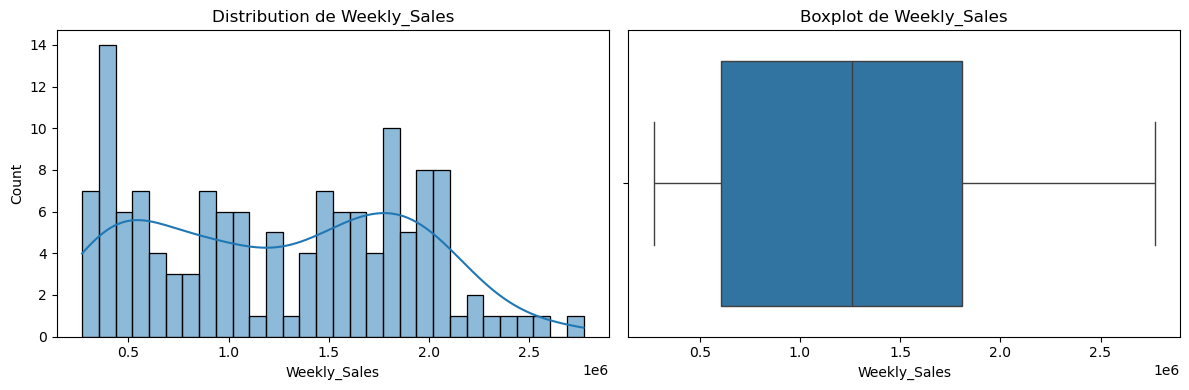

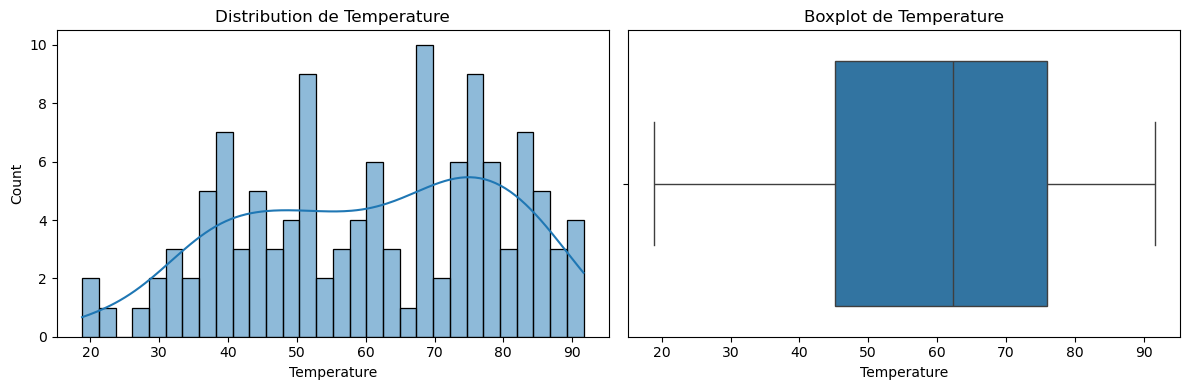

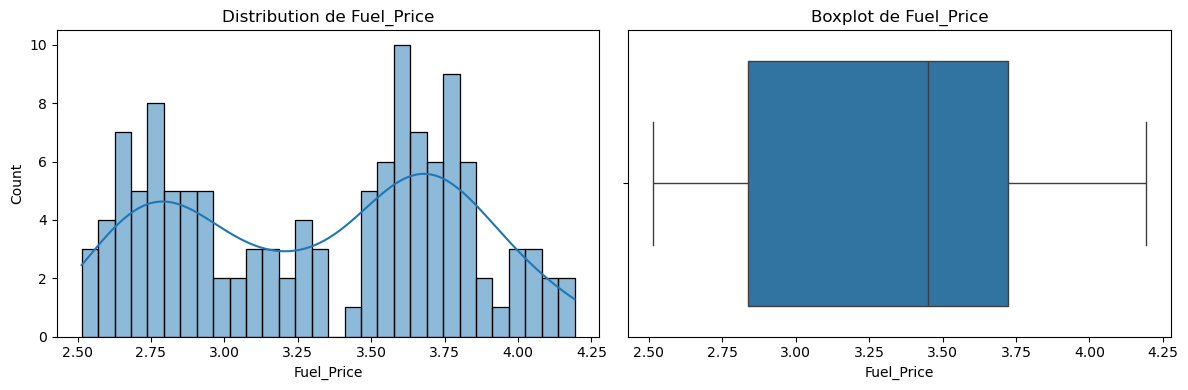

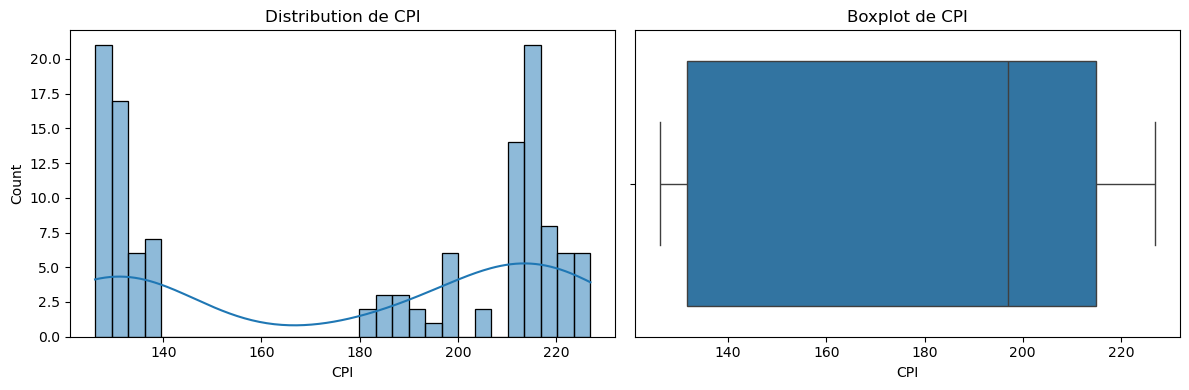

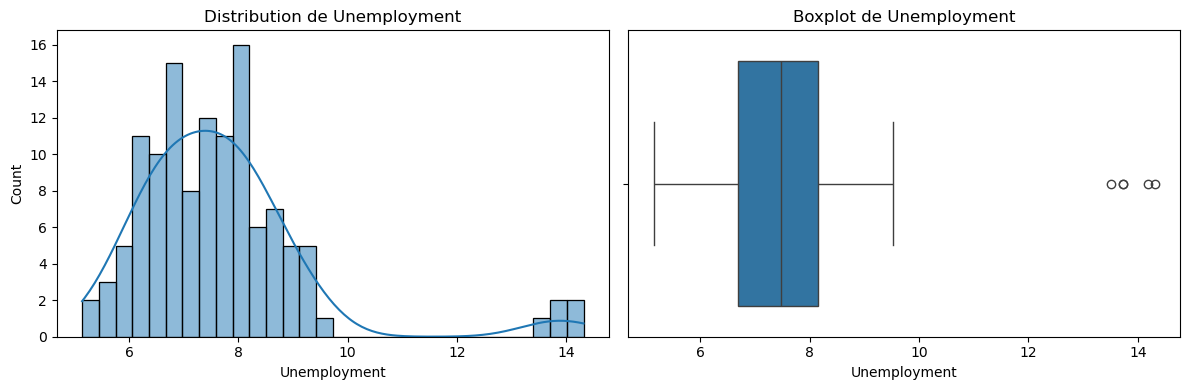

In [10]:
# Distribution of each numeric variable
num_features = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
for col in num_features:
    plt.figure(figsize=(12, 4))

    # Histogramme
    plt.subplot(1, 2, 1)
    sns.histplot(df_clean[col], kde=True, bins=30)
    plt.title(f'Distribution de {col}')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_clean[col])
    plt.title(f'Boxplot de {col}')

    plt.tight_layout()
    plt.show()

In [11]:
# Removing outliers from the Unemployment column
Q1 = df_clean['Unemployment'].quantile(0.25)
Q3 = df_clean['Unemployment'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df_clean = df_clean[(df_clean['Unemployment'] >= lower) & (df_clean['Unemployment'] <= upper)].copy()

In [12]:
df_clean.shape

(117, 11)

### Analyse bivariée

In [13]:
# Plot scatter plots for each feature in the dataset against 'Weekly_Sales'
# Adds a histogram on the x-axis to better understand data distribution
for col in df_clean.columns:
    fig = px.scatter(df_clean, x=col, y='Weekly_Sales', width=800, height=350, marginal_x='histogram')
    fig.show()

1. Store vs Weekly_Sales
- Certains magasins réalisent systématiquement des ventes plus élevées que d’autres.
- La variabilité entre magasins est importante → l’effet “Store” est probablement un facteur explicatif clé.
2. Holiday_Flag vs Weekly_Sales
- Peu de points avec Holiday_Flag = 1 (jours fériés).
- Sur ces rares cas, on voit que les ventes peuvent être élevées ou basses, il n’y a pas de tendance claire à première vue.
3. Temperature vs Weekly_Sales
- Pas de relation linéaire claire entre température et ventes.
- Les ventes semblent assez dispersées pour toutes les températures.
4. Fuel_Price vs Weekly_Sales
- Aucune tendance claire : la dispersion est importante.
- Le prix du carburant seul ne semble pas corréler fortement aux ventes dans cet échantillon.
5. CPI vs Weekly_Sales
- On distingue visuellement deux “groupes” distincts de CPI (un autour de 130 et un autour de 210).
- Dans chaque groupe, les ventes varient beaucoup.
6. Unemployment vs Weekly_Sales
- La majorité des observations sont autour de 6–8 % de chômage, mais il y a quelques points isolés autour de 14 %.
- Pas de relation simple à vue d’œil.
7. year / month / day_of_year vs Weekly_Sales
- Effet temporel possible : certains mois semblent avoir des pics (décembre notamment).
- On pourrait voir une saisonnalité annuelle ou un effet “mois” marqué.


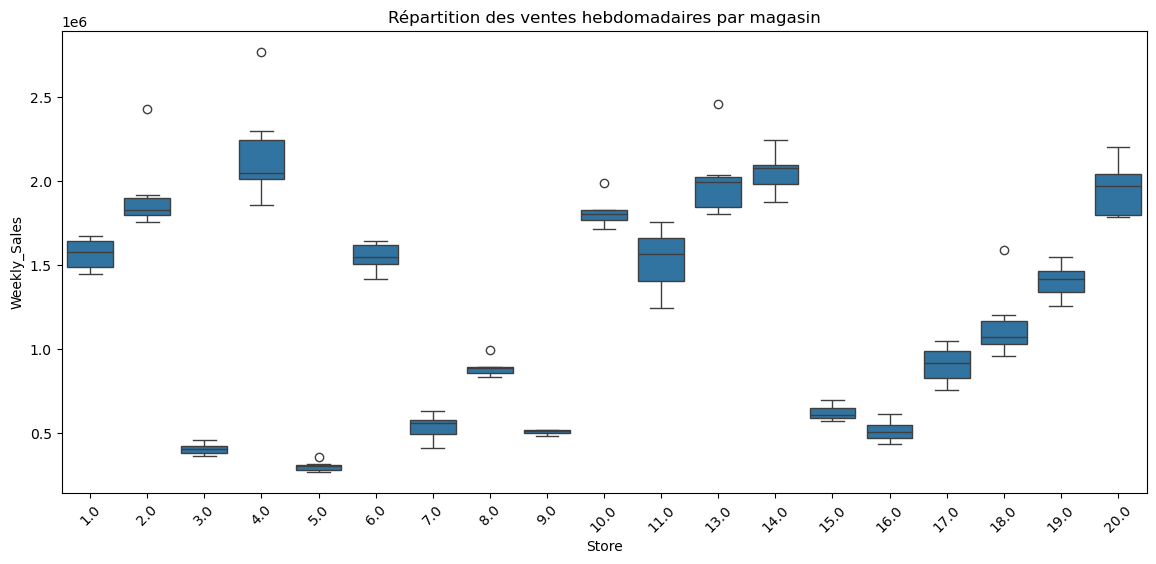

In [14]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='Store', y='Weekly_Sales', data=df_clean)
plt.title("Répartition des ventes hebdomadaires par magasin")
plt.xticks(rotation=45)
plt.show()

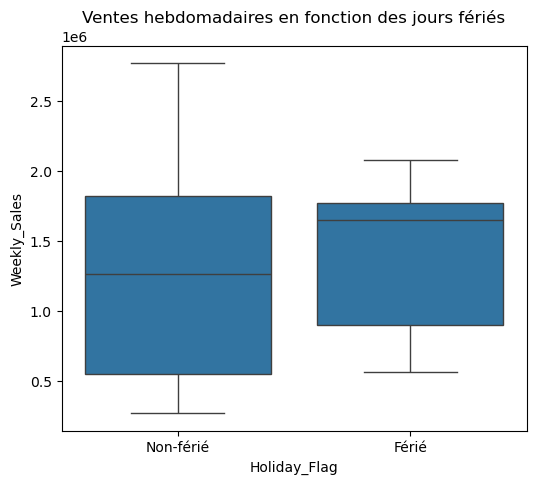

In [15]:
plt.figure(figsize=(6, 5))
sns.boxplot(x='Holiday_Flag', y='Weekly_Sales', data=df_clean)
plt.title("Ventes hebdomadaires en fonction des jours fériés")
plt.xticks([0, 1], ['Non-férié', 'Férié'])
plt.show()

In [16]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 117 entries, 0 to 149
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         117 non-null    float64
 1   Weekly_Sales  117 non-null    float64
 2   Holiday_Flag  107 non-null    float64
 3   Temperature   106 non-null    float64
 4   Fuel_Price    106 non-null    float64
 5   CPI           108 non-null    float64
 6   Unemployment  117 non-null    float64
 7   year          102 non-null    float64
 8   month         102 non-null    float64
 9   day_of_month  102 non-null    float64
 10  day_of_year   102 non-null    float64
dtypes: float64(11)
memory usage: 11.0 KB


### Analyse multivariée

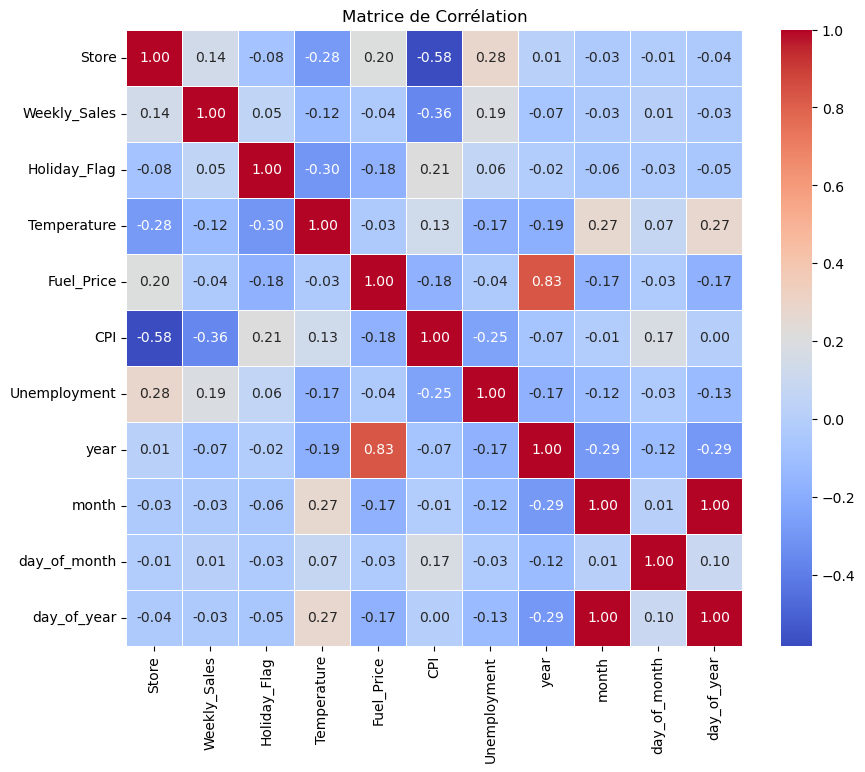

In [17]:
numeric_cols = df_clean.select_dtypes(include='number').columns

# Compute correlation matrix
corr_matrix = df_clean[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, linewidths=0.5)
plt.title("Matrice de Corrélation")
plt.show()


In [18]:
# 'year' and 'day_of_year' are highly correlated with other temporal features 
# (month, day_of_month), so we drop them to avoid multicollinearity
df_clean.drop(columns=['day_of_year'], inplace=True)
df_clean.drop(columns=['year'], inplace=True)

In [19]:
# Separate target variable Y from features X
print("Separating labels from features...")
features_list = ["Store", "Holiday_Flag", "Temperature", "Fuel_Price", "CPI", "Unemployment", "month", "day_of_month"]
target_variable = "Weekly_Sales"

X = df_clean.loc[:,features_list]
Y = df_clean.loc[:,target_variable]

print("...Done.")
print()

print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())

Separating labels from features...
...Done.

Y : 
0    1572117.54
1    1807545.43
3    1244390.03
4    1644470.66
5    1857533.70
Name: Weekly_Sales, dtype: float64

X :
   Store  Holiday_Flag  Temperature  Fuel_Price         CPI  Unemployment  \
0    6.0           NaN        59.61       3.045  214.777523         6.858   
1   13.0           0.0        42.38       3.435  128.616064         7.470   
3   11.0           0.0        84.57         NaN  214.556497         7.346   
4    6.0           0.0        78.89       2.759  212.412888         7.092   
5    4.0           0.0          NaN       2.756  126.160226         7.896   

   month  day_of_month  
0    2.0          18.0  
1    3.0          25.0  
3    NaN           NaN  
4    5.0          28.0  
5    5.0          28.0  


In [20]:
numeric_features = ['CPI', 'Temperature', 'Unemployment', 'Fuel_Price']
categorical_features = ['Store', 'Holiday_Flag', 'month', 'day_of_month']

In [21]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [22]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # missing values will be replaced by columns' median
    ('scaler', StandardScaler())
])

In [23]:
# Create pipeline for categorical features
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore')) # first column will be dropped to avoid creating correlations between features
    ])

In [24]:
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [25]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5]) # MUST use this syntax because X_train is a numpy array and not a pandas DataFrame anymore
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head()) 
X_test = preprocessor.transform(X_test) # Don't fit again !! The test set is used for validating decisions
# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
print('...Done.')
print(X_test[0:5,:]) # MUST use this syntax because X_test is a numpy array and not a pandas DataFrame anymore
print()

Performing preprocessings on train set...
     Store  Holiday_Flag  Temperature  Fuel_Price         CPI  Unemployment  \
130   13.0           0.0        52.50       3.529  130.826194         6.104   
39     5.0           0.0        60.71       3.297  218.569962         6.300   
36     3.0           0.0        80.19       3.467  219.741491         7.567   
65    10.0           NaN        43.43       3.287  127.191774         8.744   
55    13.0           0.0        63.60       3.648  129.518333         6.877   

     month  day_of_month  
130    3.0          16.0  
39    11.0          11.0  
36     9.0          23.0  
65     NaN           NaN  
55     9.0          23.0  
...Done.
  (0, 0)	-1.1768778188484725
  (0, 1)	-0.4633406173900033
  (0, 2)	-1.2796738149441738
  (0, 3)	0.3987969100787415
  (0, 14)	1.0
  (0, 24)	1.0
  (0, 48)	1.0
  (1, 0)	1.0733527618413805
  (1, 1)	0.02216648678032009
  (1, 2)	-1.0858840361941644
  (1, 3)	-0.11433438561609768
  (1, 7)	1.0
  (1, 32)	1.0
  (1, 43)	1.

## Modèles

#### Régression linéaire

In [26]:
# Train model
print("Train model...")
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [27]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = linear_regressor.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[2030173.87591078  322721.22954798  319017.44925801 1763574.70217461
 1893663.34944904  914635.76826233  275140.27484616  528091.44352483
 1616083.10242413 1655817.09501656  588305.59214289 2151648.19517022
 1569607.75156028 1894043.60954828 1014786.18499819  622521.62528579
 2389100.44575107 1502524.86121545 1110701.23772186  562751.7664878
  338636.60657954 1626145.08837681 2429742.54348885  591967.91698152
  309882.41502279 1828330.10120137 2058249.78808393 1760015.07906884
  898108.19340879 1624900.31785189 1567711.22280647 1846190.87094404
 1125194.70554083  577711.26402214 2068587.22193117  251471.99458579
 1658784.59206033  747270.72258417 1967545.49352838 2066540.7466609
  477120.70047881 1584049.83495466  937411.82058144 2048498.5159242
 2716527.24799555  518255.60737335  319733.25546036  934729.19221127
 1076661.87766152 1154661.61721654 1799737.47114298 1442068.91827124
 1964689.48747261 1497395.94983659 1980672.96932899  799010.138399

In [28]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = linear_regressor.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[ 621506.44930609 1881234.92709924  576910.8198753  1706492.29743634
  387992.36765622  714758.14278983 1661377.2086524   217720.54877969
  914373.01278486  336822.95749848  361960.55980431 1516078.90061066
 1563219.24774703  568391.11937929 1145894.45025057 2030566.3445173
 1669840.79315812 1801149.59105691 1548128.30964683 2038134.81207902
 2532898.6342593  1744713.38305574 1435352.25937387  612544.81675789]



In [29]:
print("Evaluation metrics:")
print(f"MAE (train) : {mean_absolute_error(Y_train, Y_train_pred):.2f}")
print(f"MAE (test)  : {mean_absolute_error(Y_test, Y_test_pred):.2f}")
print(f"RMSE (train): {np.sqrt(mean_squared_error(Y_train, Y_train_pred)):.2f}")
print(f"RMSE (test) : {np.sqrt(mean_squared_error(Y_test, Y_test_pred)):.2f}")
print(f"R2 (train)  : {r2_score(Y_train, Y_train_pred):.3f}")
print(f"R2 (test)   : {r2_score(Y_test, Y_test_pred):.3f}")

Evaluation metrics:
MAE (train) : 27796.79
MAE (test)  : 120621.20
RMSE (train): 36995.58
RMSE (test) : 151255.06
R2 (train)  : 0.997
R2 (test)   : 0.944


- MAE (Moyenne des valeurs absolues des erreurs): en moyenne, le modèle se trompe de 28K (train) et 121k (test) ventes hebdomadaires.
- RMSE (Racine carrée de la moyenne des erreurs au carré): en train erreur de 37k ventes/semaine - en test erreur de 151k ventes/semaine.
- => Le modèle est plutôt bon en général mais fait de grosses erreurs.
- R²: Le modèle est performant, avec un fort pouvoir explicatif, mais reste sensible aux cas particuliers. 


In [30]:
# Compute residuals (errors)
errors = Y_test - Y_test_pred      # true - predicted
abs_errors = np.abs(errors)

# Create a DataFrame with useful info
df_errors = pd.DataFrame({
    "y_true": Y_test,        # actual values
    "y_pred": Y_test_pred,   # predicted values
    "error": errors,         # residuals (true - pred)
    "abs_error": abs_errors  # absolute residuals
})

# Sort by largest absolute error
df_errors_sorted = df_errors.sort_values(by="abs_error", ascending=False)

# Show the 10 worst errors
print(df_errors_sorted.head(10))

         y_true        y_pred          error      abs_error
104   419497.95  7.147581e+05 -295260.192790  295260.192790
70   1588430.71  1.881235e+06 -292804.217099  292804.217099
3    1244390.03  1.516079e+06 -271688.870611  271688.870611
29   1420405.41  1.661377e+06 -240971.798652  240971.798652
111  1468350.36  1.706492e+06 -238141.937436  238141.937436
12    414094.05  6.215064e+05 -207412.399306  207412.399306
142   403342.40  2.177205e+05  185621.851220  185621.851220
27    435397.19  5.683911e+05 -132993.929379  132993.929379
49    485095.41  6.125448e+05 -127449.406758  127449.406758
116   457340.06  3.368230e+05  120517.102502  120517.102502


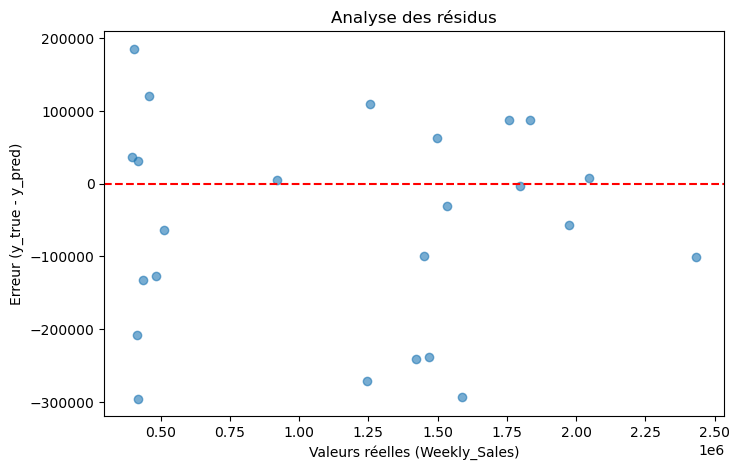

In [31]:
plt.figure(figsize=(8,5))
plt.scatter(Y_test, errors, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Valeurs réelles (Weekly_Sales)")
plt.ylabel("Erreur (y_true - y_pred)")
plt.title("Analyse des résidus")
plt.show()


- Résidus centrés autour de 0 : pas de biais systématiques
- On observe des écarts importants pour certaines valeurs de ventes (surtout sur des ventes élevées): le modèle a du mal à prédire correctement lors des pics de ventes.
- La dispersion des points montre que le modèle n'arrive pas à bien capter certains comportements. 

#### Validation croisée avec Ridge Regression

In [32]:
# Perform 3-fold cross-validation to evaluate the generalized R2 score obtained with a Ridge model
print("3-fold cross-validation...")
ridge_regressor = Ridge()
scores = cross_val_score(ridge_regressor, X_train, Y_train, cv=3)
print('The cross-validated R2-score is : ', scores.mean())
print('The standard deviation is : ', scores.std())

3-fold cross-validation...
The cross-validated R2-score is :  0.7584768955059976
The standard deviation is :  0.078961853464265


La validation croisée en 3 flod avec la régression Ridge donne un score R² moyen d’environ 0,76,
avec un écart-type d’environ 0,08 entre les flods.
Cela signifie que le modèle Ridge explique environ 76 % de la variance des ventes sur des données non vues,
avec des performances relativement stables d’un fold à l’autre.


#### Optimisation des hyperparamètres (Ridge Regression avec GridSearchCV)

In [33]:
# Grid of values to be tested
params = {
    'alpha': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]
}
best_ridge = GridSearchCV(ridge_regressor, param_grid = params, cv = 5) # cv : the number of folds to be used for CV
best_ridge.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", best_ridge.best_params_)
print("Best R2 score : ", best_ridge.best_score_)

...Done.
Best hyperparameters :  {'alpha': 0.05}
Best R2 score :  0.9125401853319675


In [34]:
best_model = best_ridge.best_estimator_

Y_train_pred = best_model.predict(X_train)
Y_test_pred  = best_model.predict(X_test)

print("Performance du meilleur modèle Ridge:")
print(f"R² (train): {r2_score(Y_train, Y_train_pred):.3f}")
print(f"R² (test) : {r2_score(Y_test, Y_test_pred):.3f}")
print(f"MAE (train): {mean_absolute_error(Y_train, Y_train_pred):.2f}")
print(f"MAE (test) : {mean_absolute_error(Y_test, Y_test_pred):.2f}")
print(f"RMSE (train): {np.sqrt(mean_squared_error(Y_train, Y_train_pred)):.2f}")
print(f"RMSE (test) : {np.sqrt(mean_squared_error(Y_test, Y_test_pred)):.2f}")

Performance du meilleur modèle Ridge:
R² (train): 0.996
R² (test) : 0.945
MAE (train): 31764.26
MAE (test) : 120106.30
RMSE (train): 42294.33
RMSE (test) : 149155.97


- La recherche par grille (GridSearchCV, cv=5) a testé plusieurs valeurs possibles pour α : [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100].
- Le meilleur hyperparamètre trouvé est α = 0.05.
- Avec ce réglage, le modèle atteint un R² moyen validé par cross-validation ≈ 0.913, ce qui est nettement meilleur que le R² moyen obtenu sans optimisation (~0.76).
- Cela montre que la régularisation Ridge, bien calibrée, permet de réduire le sur-apprentissage et d’améliorer la capacité de généralisation.

#### Recherche d'hyperparamètres pour Lasso (GridSearchCV)

In [35]:
# Perform grid search
print("Grid search...")
lasso_regressor = Lasso(max_iter=10000)
# Grid of values to be tested
params = {
    'alpha': [1, 2, 3, 5, 10, 20, 30, 50, 100, 150, 250, 350, 360, 400, 500]
}
best_lasso = GridSearchCV(lasso_regressor, param_grid = params, cv = 10) # cv : the number of folds to be used for CV
best_lasso.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", best_lasso.best_params_)
print("Best R2 score : ", best_lasso.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'alpha': 500}
Best R2 score :  0.9230905145415512


La recherche d’hyperparamètres avec **GridSearchCV** a permis d’optimiser le paramètre de régularisation **alpha** du modèle Lasso.  
Après avoir testé une large gamme de valeurs (de 1 à 500), la meilleure valeur trouvée est **500**.  

Avec cet alpha optimal, le modèle obtient un **score R² moyen en validation croisée d’environ 0.923**,  
ce qui signifie qu’il explique plus de 92 % de la variance des ventes, tout en conservant une bonne capacité de généralisation.  

Ce résultat montre que **l’augmentation du paramètre alpha améliore l’équilibre entre biais et variance**,  
en forçant les coefficients les moins pertinents à se rapprocher de zéro, ce qui rend le modèle plus robuste et interprétable.  

En résumé : le réglage d’alpha a significativement amélioré la stabilité et la performance prédictive du Lasso,  
faisant de ce modèle un choix fiable par rapport à Ridge ou à un Lasso non optimisé.


In [36]:
# Retrieve the best Lasso model
best_lasso_model = best_lasso.best_estimator_

# Predictions
y_train_pred = best_lasso_model.predict(X_train)
y_test_pred = best_lasso_model.predict(X_test)

# R² scores
r2_train = r2_score(Y_train, y_train_pred)
r2_test = r2_score(Y_test, y_test_pred)

# Mean Absolute Error (MAE)
mae_train = mean_absolute_error(Y_train, y_train_pred)
mae_test = mean_absolute_error(Y_test, y_test_pred)

# Root Mean Squared Error (RMSE)
rmse_train = np.sqrt(mean_squared_error(Y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(Y_test, y_test_pred))

print("Performance of the best Lasso model:")
print(f"R² (train): {r2_train:.3f}")
print(f"R² (test) : {r2_test:.3f}")
print(f"MAE (train): {mae_train:.2f}")
print(f"MAE (test) : {mae_test:.2f}")
print(f"RMSE (train): {rmse_train:.2f}")
print(f"RMSE (test) : {rmse_test:.2f}")


Performance of the best Lasso model:
R² (train): 0.995
R² (test) : 0.960
MAE (train): 35317.23
MAE (test) : 97050.57
RMSE (train): 47336.55
RMSE (test) : 126958.69


In [37]:
# KFold cross-validation:
# Instead of relying only on a single train/test split, we use K-Fold CV 
# to evaluate the model's performance more reliably.
# Here, the training set is split into 7 folds. For each iteration:
#  - the model is trained on 6 folds
#  - validated on the remaining 1 fold
# This process repeats 7 times, each fold serving once as validation.
# The final score is the mean performance across all folds.
# Advantage: reduces variance in evaluation and gives a more robust estimate of generalization.
kf = KFold(n_splits=7, shuffle=True, random_state=42)

# --- Linear Regression (baseline) ---
linear_regressor.fit(X_train, Y_train)
print("Linear  train R2:", linear_regressor.score(X_train, Y_train))
print("Linear  test  R2:", linear_regressor.score(X_test,  Y_test))
cv_lin = cross_val_score(linear_regressor, X_train, Y_train, cv=kf, scoring="r2")
print("Linear  CV mean:", cv_lin.mean(), " | std:", cv_lin.std())
print("------")

# --- Ridge Regression (best with grid search) ---
ridge_best = best_ridge.best_estimator_
print("Ridge   train R2:", ridge_best.score(X_train, Y_train))
print("Ridge   test  R2:", ridge_best.score(X_test,  Y_test))
cv_ridge = cross_val_score(ridge_best, X_train, Y_train, cv=kf, scoring="r2")
print("Ridge   CV mean:", cv_ridge.mean(), " | std:", cv_ridge.std())
print("------")

# --- Lasso Regression (best with grid search) ---
lasso_best = best_lasso.best_estimator_
print("Lasso   train R2:", lasso_best.score(X_train, Y_train))
print("Lasso   test  R2:", lasso_best.score(X_test,  Y_test))
cv_lasso = cross_val_score(lasso_best, X_train, Y_train, cv=kf, scoring="r2")
print("Lasso   CV mean:", cv_lasso.mean(), " | std:", cv_lasso.std())


Linear  train R2: 0.9967771532351869
Linear  test  R2: 0.9435771532763628
Linear  CV mean: 0.85651766552133  | std: 0.11169134930654422
------
Ridge   train R2: 0.9957878464367041
Ridge   test  R2: 0.9451323360288969
Ridge   CV mean: 0.8760055338675168  | std: 0.09284701038681858
------
Lasso   train R2: 0.9947236549603635
Lasso   test  R2: 0.9602479066636829
Lasso   CV mean: 0.8829310723331447  | std: 0.11172649297387455


### Comparaison des modèles (Linear, Ridge, Lasso)

#### 🔹 Régression Linéaire
- **Train R² :** ≈ 0.997  
- **Test R² :** ≈ 0.944  
- **CV mean :** ≈ 0.857 (std ≈ 0.112)  
➡️ Très bonne performance globale, mais légère sensibilité au surapprentissage (écart train/test).

---

#### 🔹 Régression Ridge
- **Train R² :** ≈ 0.996  
- **Test R² :** ≈ 0.945  
- **CV mean :** ≈ 0.876 (std ≈ 0.093)  
➡️ Stabilité légèrement meilleure que la régression linéaire, mais sans réel gain de performance.

---

#### 🔹 Régression Lasso
- **Train R² :** ≈ 0.994  
- **Test R² :** ≈ 0.960  
- **CV mean :** ≈ 0.883 (std ≈ 0.112)  
➡️ Meilleure performance sur les données de test et en validation croisée.  
➡️ Avantage supplémentaire : sélection des variables les plus pertinentes.

---

#### Conclusion
Le modèle **Lasso** est le plus performant et le plus robuste :  
il explique environ **96 % de la variance** sur les données de test,  
reste stable en validation croisée, et met en avant les prédicteurs les plus importants.  
C’est donc **le modèle recommandé** dans ce cas.

                  Variable   Coefficient  Abs_Coefficient
7           cat__Store_5.0 -1.284861e+06     1.284861e+06
5           cat__Store_3.0 -1.176008e+06     1.176008e+06
11          cat__Store_9.0 -1.056739e+06     1.056739e+06
17         cat__Store_16.0 -9.016574e+05     9.016574e+05
16         cat__Store_15.0 -8.856599e+05     8.856599e+05
9           cat__Store_7.0 -8.818804e+05     8.818804e+05
10          cat__Store_8.0 -7.149311e+05     7.149311e+05
15         cat__Store_14.0  5.873929e+05     5.873929e+05
33         cat__month_12.0  5.798047e+05     5.798047e+05
62  cat__day_of_month_31.0 -5.754725e+05     5.754725e+05
18         cat__Store_17.0 -5.631797e+05     5.631797e+05
14         cat__Store_13.0  4.636896e+05     4.636896e+05
6           cat__Store_4.0  4.561616e+05     4.561616e+05
12         cat__Store_10.0  3.787993e+05     3.787993e+05
21         cat__Store_20.0  3.369754e+05     3.369754e+05
19         cat__Store_18.0 -2.717677e+05     2.717677e+05
4           ca

<Figure size 1200x600 with 0 Axes>

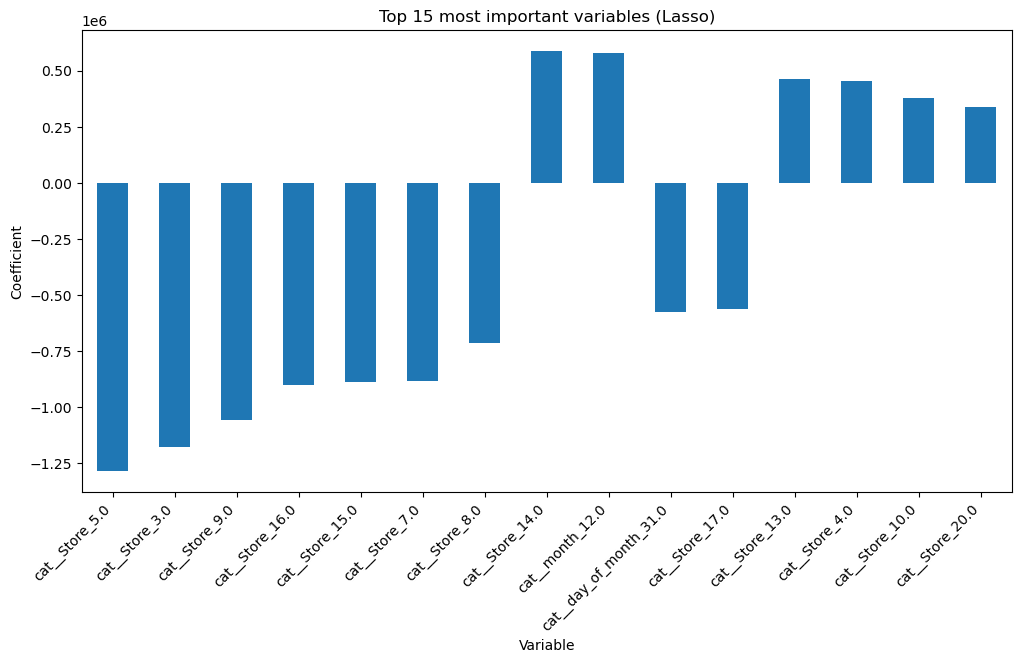

In [38]:
# Retrieve feature names after transformation
feature_names = preprocessor.get_feature_names_out()

# Create a DataFrame of coefficients
feature_importance = pd.DataFrame({
    "Variable": feature_names,
    "Coefficient": best_lasso_model.coef_
})

# Sort by absolute importance
feature_importance["Abs_Coefficient"] = feature_importance["Coefficient"].abs()
feature_importance = feature_importance.sort_values(by="Abs_Coefficient", ascending=False)

print(feature_importance.head(20))  # Top 20 variables

# Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
feature_importance.head(15).plot(
    x="Variable", y="Coefficient", kind="bar", legend=False, figsize=(12,6)
)
plt.title("Top 15 most important variables (Lasso)")
plt.ylabel("Coefficient")
plt.xticks(rotation=45, ha="right")
plt.show()


- L’analyse exploratoire (EDA) et les résultats du modèle Lasso convergent et se renforcent mutuellement.
- L’EDA a montré que certains magasins se distinguent nettement en termes de volumes de ventes hebdomadaires (par exemple, les magasins 5, 3 et 9 en dessous de la moyenne, tandis que les magasins 12, 14 et 13 affichent des ventes plus élevées).
- Le modèle Lasso, à travers ses coefficients, confirme ces tendances : les variables associées aux magasins les plus performants reçoivent des coefficients positifs importants, tandis que celles des magasins les moins performants sont pondérées négativement.
- Ainsi, l’EDA a permis d’identifier des patterns visuels et descriptifs, et le modèle statistique vient valider ces observations de manière quantitative et robuste.
- En somme, il existe une forte adéquation entre l’exploration initiale et l’apprentissage automatique : le modèle capte bien la réalité observée dans les données, ce qui renforce la confiance dans la validité des résultats et leur interprétabilité.